# Mandacaru - Desafio parte 2
## Team 2: Francisco de Asis dos Santos Silva, Josué Marinho Hinrichs and Leidy Milena Leal Abril



In this notebook, we use machine learning to create a model with the ability of classifying text of the financial sector as positive, negative or neutral sentiments. In the first section, we shall show the exploratory analysis of data including the information of dataset, verification of missing or repeated values, sentiments distributions and the words more commons. Also, we shall plot figures corresponding. In the second part, we shall clean up data carrying out the elimination of duplicated rows, the tokenization, removing the stop words and lemmatization. 
In the third part, we shall explore three methods of machine learning: Neural network, SVM and Multinomal Naive Bayes. Each model is evaluated through the accuracy, and the confusion matrix as well the learning curve are obtained. We determine that the model more adequated is the SVM. 


We import the library and packages:

In [426]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc


from yellowbrick.classifier import ROCAUC

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/milena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/milena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/milena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

We import the dataset used to train the model:

In [427]:
dataset = pd.read_csv('./data.csv')
dataset.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## a) Exploratory analysis

#### - Initial analysis of data:
We use info() to obtain the total number of columns and raws as well as the type:

In [428]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


#### - Verifying missing values. 
If there are some missing values we shall remove the corresponding row in the next item.

In [429]:
missing_v = dataset.isnull().sum()
print(missing_v)

Sentence     0
Sentiment    0
dtype: int64


#### - Description of data:
We use describe() to obtain information more detailed about the dataset:

In [430]:
dataset.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


#### - Verifying repeated rows?
If there are repeated rows we shall remove in the next section.

In [431]:
duplicates=dataset.duplicated(keep=False)
duplicate_rows=dataset[duplicates]
duplicate_rows

,Sentence,Sentiment
629,Proha Plc ( Euronext :7327 ) announced today (...,neutral
815,SSH Communications Security Corporation is hea...,neutral
1825,Proha Plc ( Euronext :7327 ) announced today (...,neutral
1859,SSH Communications Security Corporation is hea...,neutral
2234,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
2553,The issuer is solely responsible for the conte...,neutral
2672,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
3079,The company serves customers in various indust...,neutral
3272,The company serves customers in various indust...,neutral
3353,The report profiles 614 companies including ma...,neutral


#### - Sentiments distribution:
We count the type of sentiments and determine the percentage of each sentiment. Also, we plot a histogram to show the results:

/tmp/ipykernel_1087648/766038976.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  figure=sns.countplot(x=dataset['Sentiment'],order=dataset['Sentiment'].value_counts(ascending=False).index,palette="CMRmap_r",saturation=0.9)


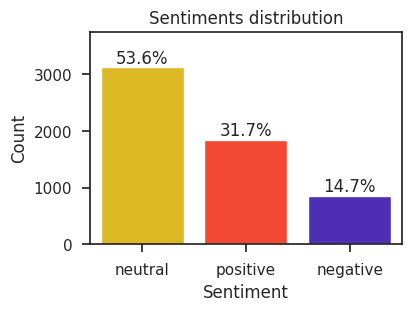

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

In [432]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
#c=sns.countplot(x='Sentiment', data=dataset,palette="CMRmap_r",saturation=1)
figure=sns.countplot(x=dataset['Sentiment'],order=dataset['Sentiment'].value_counts(ascending=False).index,palette="CMRmap_r",saturation=0.9)
total=dataset['Sentiment'].count()
for i in range(3):
    figure.bar_label(figure.containers[i],fmt=lambda x: f'{(x/total)*100:0.1f}%')
figure.margins(y=0.2)
figure.set(xlabel='Sentiment',ylabel='Count',title='Sentiments distribution')
plt.tick_params(bottom = 'off', left = 'off')
plt.savefig('./images/Sentiments_distribution.png',dpi=300)
plt.show()

dataset['Sentiment'].value_counts()


#### Exploring the length of texts (string):
We obtain statistical information about the first column i.e about 'Sentences':

In [433]:
dataset['length_text'] = dataset['Sentence'].apply(len)
dataset['length_text'].describe()

count    5842.000000
mean      117.020712
std        56.417790
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: length_text, dtype: float64

##### Boxplot of the full text:

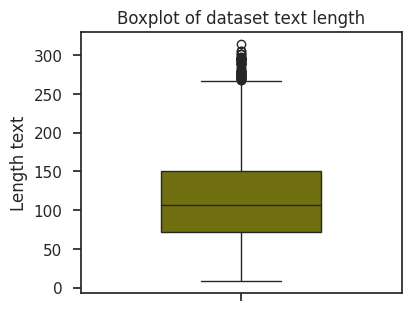

In [434]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
figure=sns.boxplot(dataset['length_text'],color='olive',width=0.5)
figure.set(ylabel='Length text',title='Boxplot of dataset text length')
plt.tick_params(bottom = 'off', left = 'off')
plt.savefig('./images/Boxplot_datasetTextLength.png',dpi=300)
plt.show()

##### Histograma

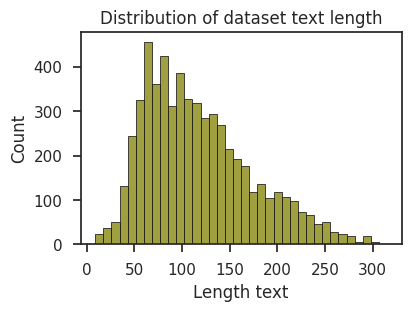

In [435]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
sns.set_theme(style='white')
figure=sns.histplot(dataset['length_text'],color='olive',ec='k')
figure.set(xlabel='Length text',ylabel='Count',title='Distribution of dataset text length')
plt.savefig('./images/Histogram_datasetTextLength.png',dpi=300)
plt.tick_params(bottom = 'off', left = 'off')
plt.show()
#

### - Length of the text by group:
We classify the text by sentiment and obtain the length of the text:

/tmp/ipykernel_1087648/2401165628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  figure=sns.boxplot(x=dataset['Sentiment'],y=dataset['Sentence'].apply(len),order=dataset['Sentiment'].value_counts(ascending=False).index,width=0.5,palette="CMRmap_r",saturation=0.9)


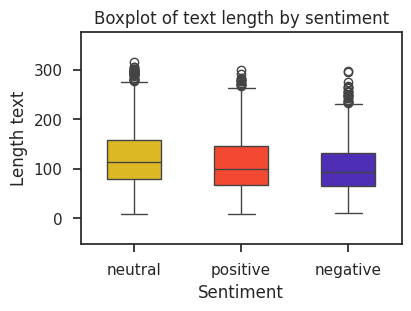

In [436]:
fig=plt.figure(figsize=(4,3),constrained_layout=True)
figure=sns.boxplot(x=dataset['Sentiment'],y=dataset['Sentence'].apply(len),order=dataset['Sentiment'].value_counts(ascending=False).index,width=0.5,palette="CMRmap_r",saturation=0.9)
figure.set(ylabel='Length text',title='Boxplot of text length by sentiment')
figure.margins(y=0.2)
plt.tick_params(bottom = 'off', left = 'off')
plt.savefig('./images/Boxplot_groupTextLength.png',dpi=300)
#plt.show()


### Words most common:

In [437]:
def dataset_token(dataset):
    dataset_tokens = []
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    for entry in dataset['Sentence']:
        tokens = nltk.tokenize.word_tokenize(entry) 
        word_norm=[word.lower() for word in tokens if word.isalpha()]
        
        rows=[word for word in word_norm if word not in stopwords]
        dataset_tokens.append(rows)
    return dataset_tokens

def words_common(dataset_tokens,n):
    words_only=[]
    for entry in dataset_tokens:
        words_only.extend(entry)
    freq_dist=nltk.FreqDist(words_only)
    words = freq_dist.most_common(n)
    return words
tokens=dataset_token(dataset)

words_commons_dataset=words_common(tokens,100)
words_commons_dataset


[('eur', 1284),
 ('company', 809),
 ('mn', 729),
 ('profit', 568),
 ('sales', 560),
 ('finnish', 527),
 ('said', 516),
 ('net', 499),
 ('million', 493),
 ('operating', 371),
 ('mln', 349),
 ('period', 331),
 ('year', 330),
 ('group', 326),
 ('finland', 319),
 ('quarter', 311),
 ('share', 285),
 ('new', 274),
 ('oyj', 250),
 ('business', 246),
 ('first', 240),
 ('market', 230),
 ('shares', 229),
 ('loss', 220),
 ('also', 211),
 ('today', 199),
 ('compared', 199),
 ('services', 194),
 ('euro', 192),
 ('helsinki', 170),
 ('corresponding', 158),
 ('per', 150),
 ('operations', 150),
 ('percent', 144),
 ('total', 144),
 ('contract', 143),
 ('http', 139),
 ('financial', 135),
 ('price', 133),
 ('https', 132),
 ('bank', 131),
 ('decreased', 131),
 ('nokia', 126),
 ('products', 124),
 ('hel', 124),
 ('stock', 122),
 ('corporation', 121),
 ('according', 115),
 ('pct', 115),
 ('capital', 114),
 ('production', 113),
 ('increased', 109),
 ('mobile', 108),
 ('plant', 107),
 ('companies', 106),
 ('la

#### Figure of distribution of the words of Full Dataset

/tmp/ipykernel_1087648/686493708.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df, palette="CMRmap_r",saturation=0.9)


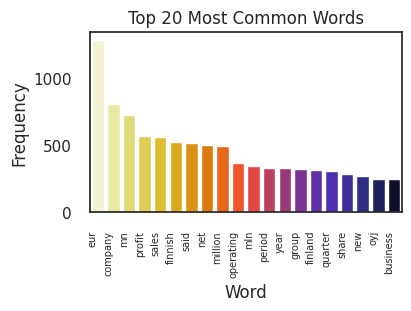

In [438]:

def plot_word_histogram(frequencies, top_n):
    sorted_frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
    top_words, top_counts = zip(*sorted_frequencies[:top_n])
    df = pd.DataFrame({'Word': top_words, 'Frequency': top_counts})

    fig=plt.figure(figsize=(4,3),constrained_layout=True)
    sns.barplot(x='Word', y='Frequency', data=df, palette="CMRmap_r",saturation=0.9)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Common Words')
    plt.xticks(rotation=90, ha='right',fontsize=7)
    plt.savefig('./images/plot_word_distribution.png')

# Example of usage
name_file='distribution_words'
plot_word_histogram(words_commons_dataset, top_n=20)


#### Distribution of the adjetives for positive sentiment:

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/milena/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/tmp/ipykernel_1087648/686493708.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df, palette="CMRmap_r",saturation=0.9)


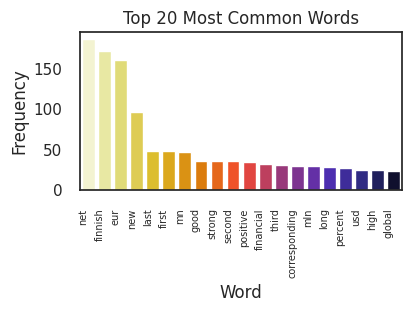

In [439]:
nltk.download('averaged_perceptron_tagger')
def extract(dataset,sentiment):
    grouped=dataset.groupby(dataset.Sentiment)
    type_sentiment=grouped.get_group(sentiment)
    #TLsentiment = type_sentiment['Sentence'].apply(len)
    return type_sentiment
def adjetives_dataset(dataset_tokens):
    new_col=[]
    for linha in tokens:
        #norm_words=[word.lower() for word in linha if word.isalpha()]
        ps_tagger=nltk.pos_tag(linha)
        n_adj=[i[0] for i in ps_tagger if i[1]=='JJ']
        new_col.append(n_adj)
    return new_col

positive = extract(dataset,'positive')
tokens=dataset_token(positive)
dataset_adjetives = adjetives_dataset(tokens)
#print(dataset_adjetives)
words_commons_dataset=words_common(dataset_adjetives,100)
#words_commons_dataset
name_file='distribution_adjetives_positive'
plot_word_histogram(words_commons_dataset, top_n=20)

#### Distribution of the adjetives for negative sentiment:

/tmp/ipykernel_1087648/686493708.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df, palette="CMRmap_r",saturation=0.9)


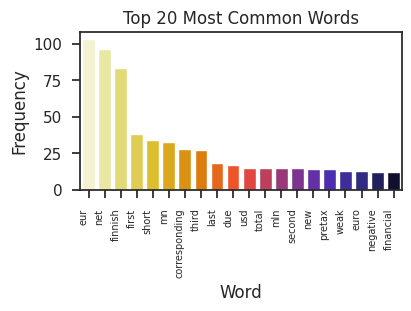

In [440]:
negative = extract(dataset,'negative')
tokens=dataset_token(negative)
dataset_adjetives = adjetives_dataset(tokens)
#print(dataset_adjetives)
words_commons_dataset=words_common(dataset_adjetives,100)
#words_commons_dataset
name_file='distribution_adjetives_negative'
plot_word_histogram(words_commons_dataset, top_n=20)
plt.tick_params(bottom = 'off', left = 'off')


#### Distribution of the adjetives for neutral sentiment:

/tmp/ipykernel_1087648/686493708.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df, palette="CMRmap_r",saturation=0.9)


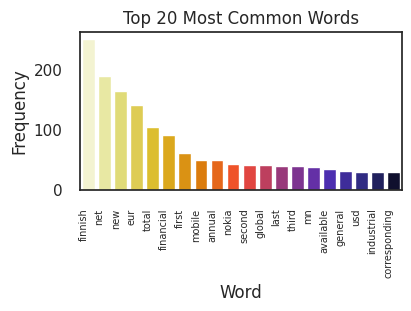

In [441]:
neutral = extract(dataset,'neutral')
tokens=dataset_token(neutral)
dataset_adjetives = adjetives_dataset(tokens)
#print(dataset_adjetives)
words_commons_dataset=words_common(dataset_adjetives,100)
#words_commons_dataset
name_file='distribution_adjetives_neutral'
plot_word_histogram(words_commons_dataset, top_n=20)

## b) Cleaning up data:

### - Removing the repeated rows:

In [442]:
dataset = dataset.drop_duplicates(keep='last')

### - Tokenizing and removing the stop words:

In [443]:
nltk.download('wordnet')
texts = dataset['Sentence']
labels = dataset['Sentiment']

# Função para normalizar os texto
def normalize(text):
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text.lower())

    # Filtrar palavras
    filtered_words = [word for word in tokens if word not in stopwords and word.isalpha()]

    # Lematização
    lemma = nltk.WordNetLemmatizer()
    lemmatized = [lemma.lemmatize(word) for word in filtered_words]
    return lemmatized

texts=dataset['Sentence'].apply(normalize)

new_col=[]
for i in texts:
    m= ' '.join(i)   
    new_col.append(m)

dataset['tokens']=new_col

[nltk_data] Downloading package wordnet to /home/milena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## c) Analysis de algorithms of machine Learning: 

### Neural Network

In [444]:
# Here we convert the tokens to integer sequences wiht the function fit_on_texts:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['tokens'])
X_sequences = tokenizer.texts_to_sequences(dataset['tokens'])


# An example of the first row: 
col2=X_sequences[0]
example_sequences=pd.DataFrame({'Tokens':texts[0],'Sequences':col2})
example_sequences.head(5)

,Tokens,Sequences
0,geosolutions,3130
1,technology,53
2,leverage,2468
3,benefon,1176
4,gps,1588


In [445]:
# We ensure that sequences have the same length by padding. 
#The maximum length corresponds to the maximun size of words in each row.
print('The sequences must have length:',  max([len(i) for i in X_sequences]))

X_padded = pad_sequences(X_sequences) 
print('Example of X_padded:',len(X_padded[0]))

The sequences must have length: 35
Example of X_padded: 35


In [446]:
#We label the sentiments as positive=2, neutral=1 and negative=0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(dataset['Sentiment'])
print(y_encoded)

[2 0 2 ... 1 1 2]


In [447]:
# We split the text between train = 70% and test=30%:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [448]:
#Wecreate the model Sequential with three layers: Embedding, LSTM and Dense exaplained as follows:
#The embedding converts the integers numbers in vectores of size 100
#The LSTM helps with the problem of Long-term in sequences.
#The dense is connected to the output for the classification of the three sentiments.

embedding_dim = 100 
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_padded.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))  # 3 sentiments

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2,verbose=1)


Epoch 1/10
59/59 [==============================] - 4s 35ms/step - loss: 0.9806 - accuracy: 0.5289 - val_loss: 0.9194 - val_accuracy: 0.5450
Epoch 2/10
59/59 [==============================] - 2s 31ms/step - loss: 0.7502 - accuracy: 0.6690 - val_loss: 0.7758 - val_accuracy: 0.6585
Epoch 3/10
59/59 [==============================] - 2s 30ms/step - loss: 0.4491 - accuracy: 0.8174 - val_loss: 0.8047 - val_accuracy: 0.6574
Epoch 4/10
59/59 [==============================] - 2s 30ms/step - loss: 0.2950 - accuracy: 0.8755 - val_loss: 0.9605 - val_accuracy: 0.6296
Epoch 5/10
59/59 [==============================] - 2s 31ms/step - loss: 0.2258 - accuracy: 0.8945 - val_loss: 1.0065 - val_accuracy: 0.6242
Epoch 6/10
59/59 [==============================] - 2s 30ms/step - loss: 0.1900 - accuracy: 0.9100 - val_loss: 1.1976 - val_accuracy: 0.6167
Epoch 7/10
59/59 [==============================] - 2s 30ms/step - loss: 0.1784 - accuracy: 0.9057 - val_loss: 1.2182 - val_accuracy: 0.6231
Epoch 8/10
59

In [449]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 35, 100)           864600    
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_11 (Dense)            (None, 3)                 303       
                                                                 
Total params: 945303 (3.61 MB)
Trainable params: 945303 (3.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Accuracy:

In [450]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

 1/37 [..............................] - ETA: 0s - loss: 0.6253 - accuracy: 0.7188

37/37 [==============================] - 0s 5ms/step - loss: 1.2881 - accuracy: 0.6670
Test set
  Loss: 1.288
  Accuracy: 0.667


#### Classification report:

In [451]:
y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
names = {0:'Negative',1:'Neutral',2:'Positive'}
result=classification_report(y_test,y_pred_classes, target_names=names.values())
print(result)

37/37 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    Negative       0.30      0.26      0.28       164
     Neutral       0.74      0.76      0.75       628
    Positive       0.68      0.69      0.69       376

    accuracy                           0.67      1168
   macro avg       0.57      0.57      0.57      1168
weighted avg       0.66      0.67      0.66      1168



#### Confusion matrix

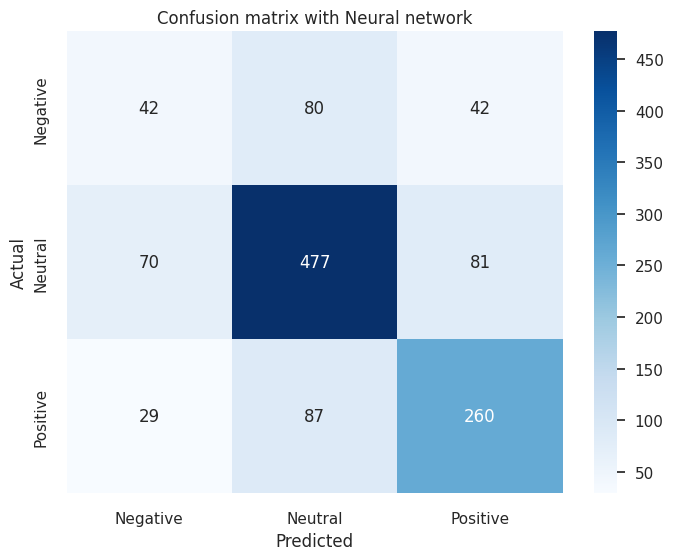

In [452]:
conf_matrix=confusion_matrix(y_test,y_pred_classes)

#plt.figure(figsize=(4,3),dpi=300,layout='constrained')
plt.figure(figsize=(8, 6))
matrix=sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=names.values(),yticklabels=names.values())
matrix.set(xlabel='Predicted',ylabel='Actual',title='Confusion matrix with Neural network')
plt.savefig('./images/confusion-matrix-neural-network.png',dpi=300)
#plt.tick_params(bottom = 'off', left = 'off')
plt.show()


#### The learning curve:

In [453]:
train_accuracy=Model.history['accuracy']
val_accuracy=Model.history['val_accuracy']
train_loss=Model.history['loss']
val_loss=Model.history['val_loss']

epochs=range(1,len(train_accuracy) +1)

##### Learning curve of Precision

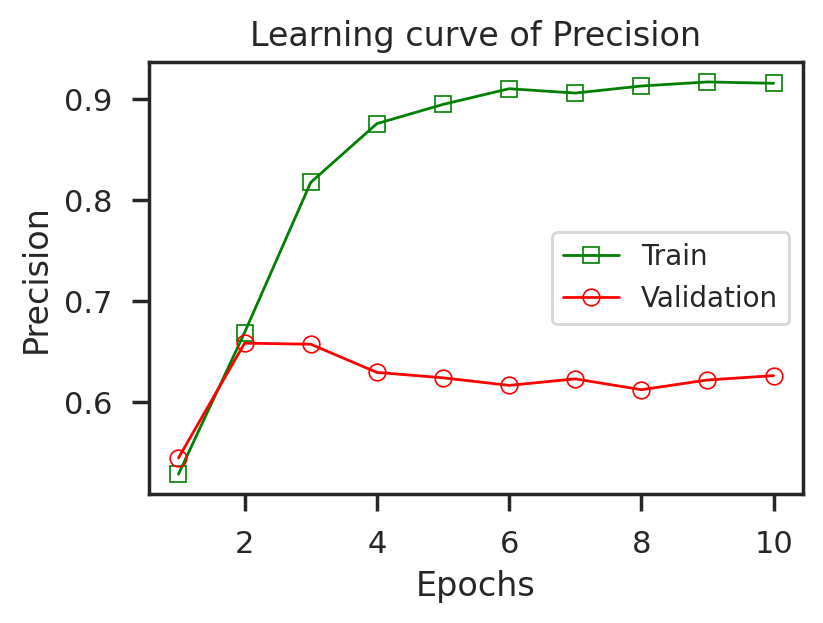

In [454]:
def Learning_curve(x,y,y1,y_name,name_savefig):
    fig,ax=plt.subplots(figsize=(4,3),dpi=200,constrained_layout=True)
    plt.plot(x,y,ms=6,marker='s',color='green',
                    label='Train',markerfacecolor='none',lw=1,
                    alpha=1,zorder=10,markeredgewidth=0.6)
    plt.plot(x,y1,ms=6,marker='o',color='red',
                    label='Validation',markerfacecolor='none',lw=1,
                    alpha=1,zorder=10,markeredgewidth=0.6)
    plt.title('Learning curve of '+y_name)
    plt.xlabel('Epochs')
    plt.ylabel(y_name)
    plt.tick_params(bottom = 'off', left = 'off')
    plt.legend(frameon=True,fontsize=10)
    plt.savefig('./images/'+name_savefig+'.png')
    plt.show()
y_name='Precision'
Learning_curve(epochs,train_accuracy,val_accuracy,y_name,'NN_Learning_curve_'+y_name)

##### Learning curve of Loss

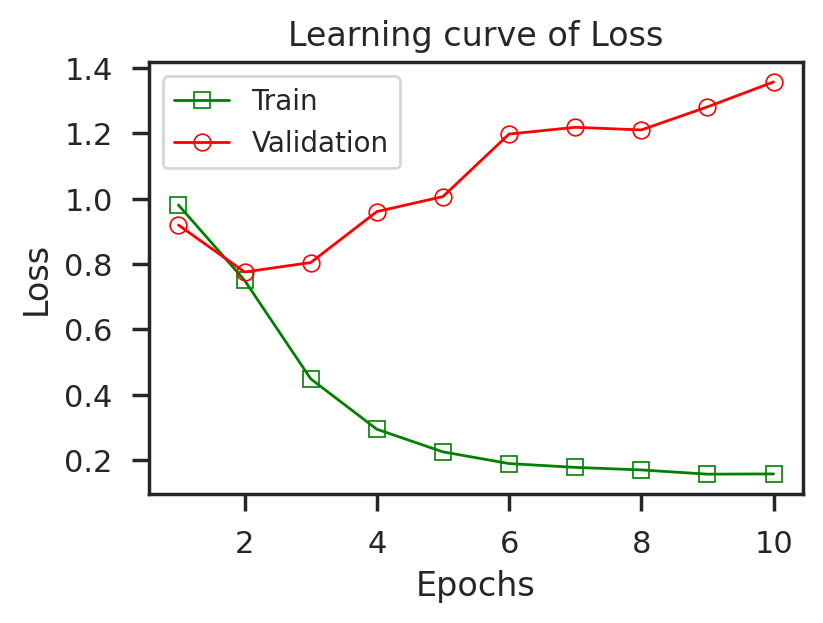

In [455]:
y_name='Loss'
Learning_curve(epochs,train_loss,val_loss,y_name,'NN_Learning_curve_'+y_name)

### Multinomial Naive Bayes

In [456]:
texts = dataset['Sentence']
labels = dataset['Sentiment']

# We apply the TFID
vectorizer = CountVectorizer(
    tokenizer=normalize)

X = vectorizer.fit_transform(texts)

# We use the labels (used in the previous model)
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(labels)

# We split the data in train (70%) e test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

/home/milena/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [457]:
# Train the mode Naive Bayes Multinomial
model = MultinomialNB()
model.fit(X_train, y_train)

# We apply the model to predict
y_pred = model.predict(X_test)

#### Accuracy:

In [458]:
# Accuracy
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.6927470017133067


#### Cross validation:

In [459]:
# Cross validation
cv_scores = cross_val_score(model, X, Y, cv=5)
print("Scores de Validação Cruzada:", cv_scores)
print("Média dos Scores de Validação Cruzada:", np.mean(cv_scores))

Scores de Validação Cruzada: [0.66695205 0.68123393 0.67866324 0.6949443  0.67523565]
Média dos Scores de Validação Cruzada: 0.6794058351234284


#### Classification report:

In [460]:
print("\nGeneral results:\n\n",classification_report(y_test, y_pred, target_names=label_encoder.classes_))


General results:

               precision    recall  f1-score   support

    negative       0.38      0.34      0.36       253
     neutral       0.76      0.78      0.77       938
    positive       0.71      0.70      0.71       560

    accuracy                           0.69      1751
   macro avg       0.62      0.61      0.61      1751
weighted avg       0.69      0.69      0.69      1751



#### Confusion matrix:

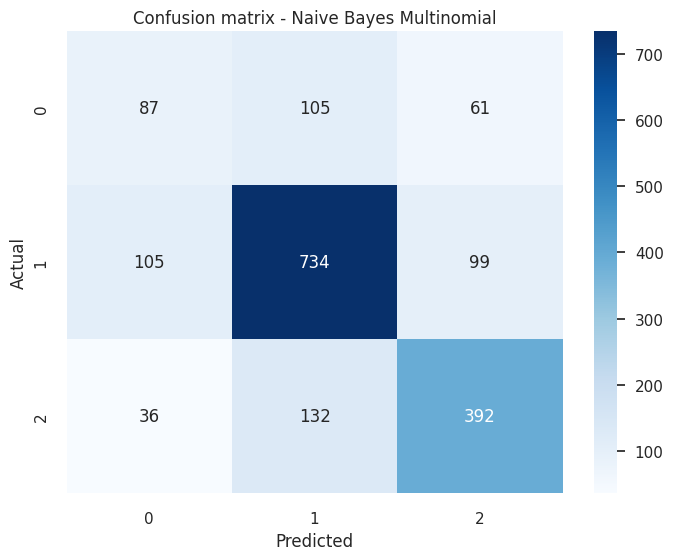

In [461]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
matrix=sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion matrix - Naive Bayes Multinomial')
matrix.set(xlabel='Predicted',ylabel='Actual')
plt.savefig('./images/confusion-matrix-multinomial-naive-bayes.png',dpi=300)
plt.show()


In [462]:
#Learning curve for accuracy
train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB(), X, Y, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

# Mean and standard deviation of the accuracy to train and test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


#### The learning curve

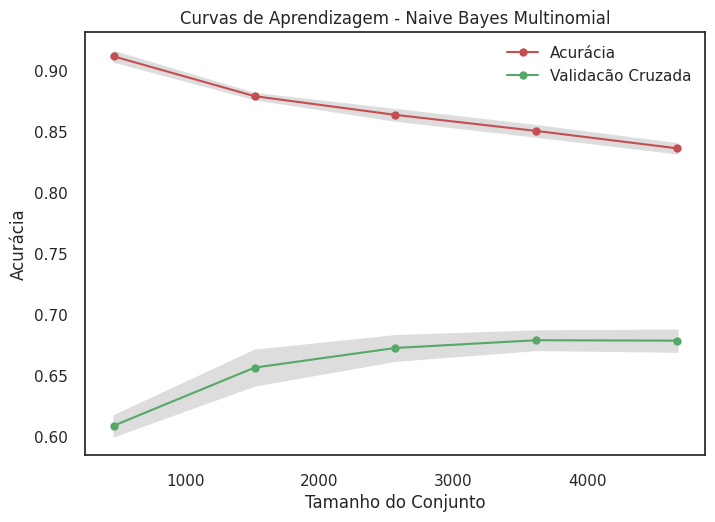

In [463]:

# Plot of Learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Acurácia")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validacão Cruzada")

plt.title("Curvas de Aprendizagem - Naive Bayes Multinomial")
plt.xlabel("Tamanho do Conjunto")
plt.ylabel("Acurácia")
plt.legend(loc="best")
plt.savefig('./images/training-curve-multinomial-naive-bayes.png',dpi=300)
plt.show()



#### ROC Curve

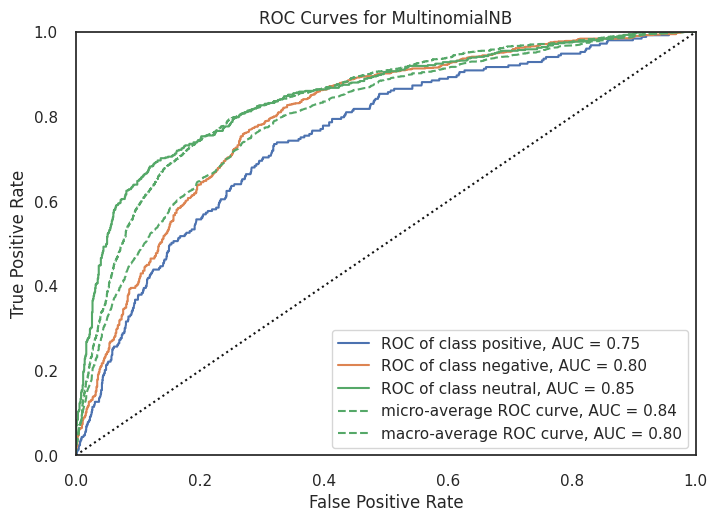

<Axes: title={'center': 'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [464]:
visualizer = ROCAUC(model, classes=["positive", "negative", "neutral"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.savefig('./images/roc-curve-multinomial-naive-bayes.png',dpi=300)
visualizer.show()

### SVM

In [465]:
# Dividindo o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(dataset['Sentence'], dataset['Sentiment'], test_size=0.3, random_state=42)

# Convertendo os conjuntos de treinamento e teste para o tipo de dados string
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Inicializando o vetorizador TF-IDF
vectorizer = TfidfVectorizer()

In [466]:
# Inicializando a validação cruzada
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [467]:
# Configurando a semente para a geração de números aleatórios
np.random.seed(1)

# Criando um pipeline para o vetorizador e o classificador SVM
pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

# Configurando a busca em grade para otimização dos hiperparâmetros do modelo
grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="accuracy", 
                    verbose=1,   
                    n_jobs=-1) 

# Treinando o modelo com a busca em grade
grid_svm.fit(X_train, y_train)

# Selecionando o melhor estimador encontrado pela busca em grade
model = grid_svm.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [468]:
# Treinando o modelo com o conjunto de treinamento
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

#### Accuracy:

In [469]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6938892061679041


#### Classification report:

In [470]:
print("\nResults:\n\n",classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Results:

               precision    recall  f1-score   support

    negative       0.38      0.58      0.46       253
     neutral       0.80      0.72      0.76       938
    positive       0.75      0.70      0.73       560

    accuracy                           0.69      1751
   macro avg       0.64      0.67      0.65      1751
weighted avg       0.72      0.69      0.70      1751



#### Confusion matrix

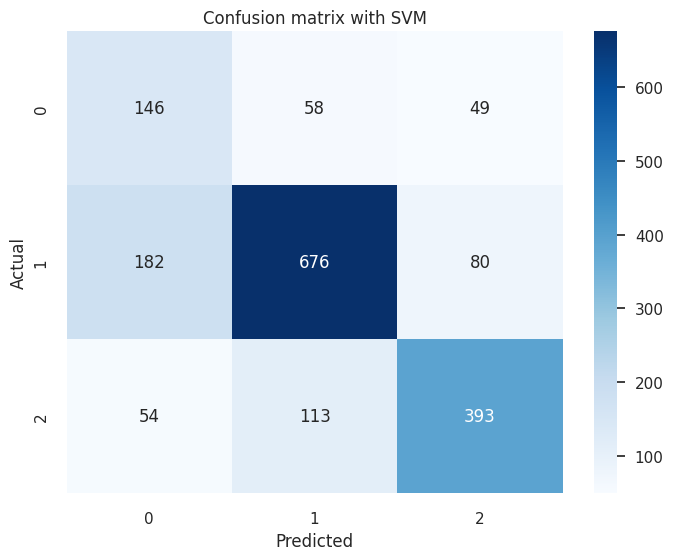

In [471]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
matrix=sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
matrix.set(xlabel='Predicted',ylabel='Actual',title='Confusion matrix with SVM')
plt.savefig('./images/confusion-matrix-svm.png',dpi=300)
plt.show()


#### The learning curve:

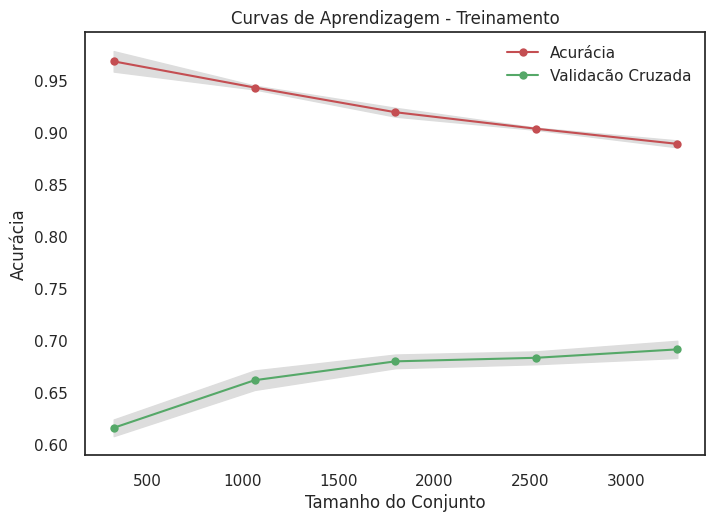

In [472]:

# Curvas de aprendizagem para acurácia
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

# Média e o desvio padrão da acurácia do treinamento e teste
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotando as curvas de aprendizagem
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Acurácia")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validacão Cruzada")

plt.title("Curvas de Aprendizagem - Treinamento")
plt.xlabel("Tamanho do Conjunto")
plt.ylabel("Acurácia")
plt.legend(loc="best")
plt.savefig('./images/training-curve-svm.png',dpi=300)
plt.show()

#### ROC Curve

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

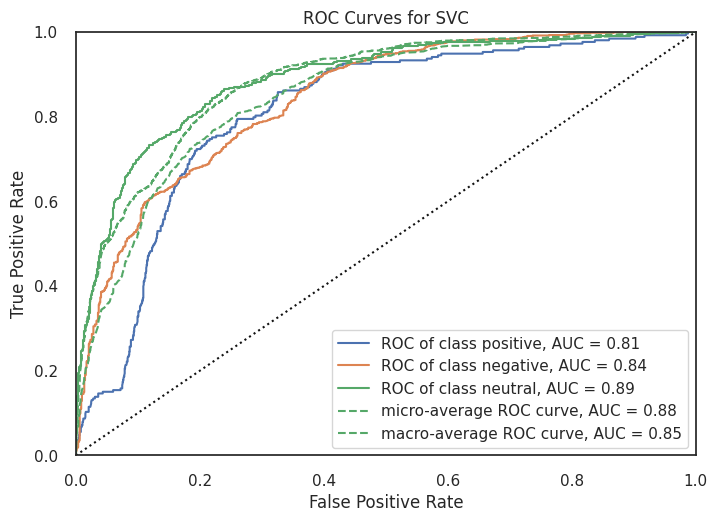

In [473]:
# Curva ROC
visualizer = ROCAUC(model, classes=["positive", "negative", "neutral"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath="./images/roc-curve-svm.png")